# PREDATOR PREY

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def predprey_rhs(t, x, u, params):
    # Parameter setup
    a = params.get('a', 3.2)
    b = params.get('b', 0.6)
    c = params.get('c', 50.)
    d = params.get('d', 0.56)
    k = params.get('k', 125)
    r = params.get('r', 1.6)

    # Map the states into local variable names
    H = x[0]
    L = x[1]

    # Compute the control action (only allow addition of food)
    u_0 = u if u > 0 else 0

    # Compute the discrete updates
    dH = (r + u_0) * H * (1 - H/k) - (a * H * L)/(c + H)
    dL = b * (a * H *  L)/(c + H) - d * L

    return [dH, dL]

In [3]:
io_predprey = control.NonlinearIOSystem(
    predprey_rhs, None, inputs=('u'), outputs=('H', 'L'),
    states=('H', 'L'), name='predprey')

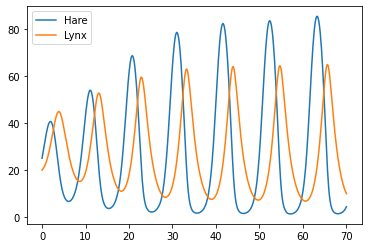

In [4]:
# Simulate the system
X0 = [25, 20]                 # Initial H, L
T = np.linspace(0, 70, 500)   # Simulation 70 years of time

# Simulate the system
t, y = control.input_output_response(io_predprey, T, 0, X0)

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
plt.show(block=False)

In [5]:
# Create a feedback controller. Step 1: Find an equalibrium point
eqpt = control.find_eqpt(io_predprey, X0, 0)
xeq = eqpt[0]                         # choose the nonzero equilibrium point
lin_predprey = control.linearize(io_predprey, xeq, 0)

/home/ubuntu/controlSBML/ctl/lib/python3.6/site-packages/control/iosys.py:1007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(xdot).reshape((-1,))


In [6]:
# Step 2: Construct the controller via pole placement
K = control.place(lin_predprey.A, lin_predprey.B, [-0.1, -0.2])
A, B = lin_predprey.A, lin_predprey.B
C = np.array([[0, 1]])                # regulated output = number of lynxes
kf = -1/(C @ np.linalg.inv(A - B @ K) @ B)

In [8]:
# Construct the controller
io_controller = control.NonlinearIOSystem(
  None,
  lambda t, x, u, params: -K @ (u[1:] - xeq) + kf * (u[0] - xeq[1]),
  inputs=('Ld', 'u1', 'u2'), outputs=1, name='control')

In [9]:
# Create the closed loop system
io_closed = control.interconnect(
  [io_predprey, io_controller],       # systems
  connections=[
    ['predprey.u', 'control.y[0]'],
    ['control.u1',  'predprey.H'],
    ['control.u2',  'predprey.L']
  ],
  inplist=['control.Ld'],
  outlist=['predprey.H', 'predprey.L', 'control.y[0]']
)

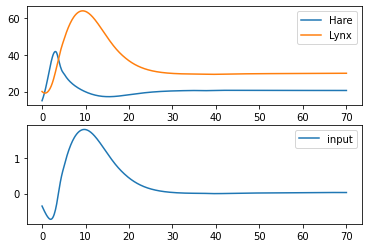

In [10]:
# Simulate the system
t, y = control.input_output_response(io_closed, T, 30, [15, 20])

# Plot the response
plt.figure(2)
plt.subplot(2, 1, 1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
plt.subplot(2, 1, 2)
plt.plot(t, y[2])
plt.legend(['input'])
plt.show(block=False)